In [3]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [4]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 12

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

# Data Information in DataFrame

In [5]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "./"

TRAIN_DF = pd.read_csv("TRAIN.csv")
TEST_DF  = pd.read_csv("TEST.csv" )

In [6]:
TRAIN_DF.head()

,filename,lesion_id,image_id,dx,dx_type,age,sex,localization
0,akiec/ISIC_0024372.jpg,HAM_0005389,ISIC_0024372,akiec,histo,70,male,lower extremity
1,akiec/ISIC_0024418.jpg,HAM_0003380,ISIC_0024418,akiec,histo,75,female,lower extremity
2,akiec/ISIC_0024450.jpg,HAM_0005505,ISIC_0024450,akiec,histo,50,male,upper extremity
3,akiec/ISIC_0024463.jpg,HAM_0004568,ISIC_0024463,akiec,histo,50,male,upper extremity
4,akiec/ISIC_0024468.jpg,HAM_0006301,ISIC_0024468,akiec,histo,75,male,neck


In [7]:
TEST_DF.head()

,filename,lesion_id,image_id,dx,dx_type,age,sex,localization
0,akiec/ISIC_0024329.jpg,HAM_0002954,ISIC_0024329,akiec,histo,75,female,lower extremity
1,akiec/ISIC_0024707.jpg,HAM_0005448,ISIC_0024707,akiec,histo,60,male,face
2,akiec/ISIC_0024710.jpg,HAM_0004609,ISIC_0024710,akiec,histo,75,male,back
3,akiec/ISIC_0025247.jpg,HAM_0005231,ISIC_0025247,akiec,histo,70,male,lower extremity
4,akiec/ISIC_0025368.jpg,HAM_0004472,ISIC_0025368,akiec,histo,40,female,face


# Flow From DataFrame

In [8]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

In [25]:
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=TRAIN_DF,
    directory="../TRAIN",
    x_col="filename",
    y_col="dx",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

Found 79 validated image filenames belonging to 3 classes.


In [10]:
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [26]:
TEST_GENERATOR = DATAGEN_TEST.flow_from_dataframe(
    dataframe=TEST_DF,
    directory="../TEST",
    x_col="filename",
    y_col="dx",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical")

Found 106 validated image filenames belonging to 3 classes.


In [27]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TRAIN_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TRAIN_GENERATOR.batch_index)

c:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


item[0]: (12, 224, 224, 3)
item[1]: (12, 3)
batch_index: 0


# Deep learning model architecture

In [28]:
BaseModel = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(BaseModel.output)
predictions = Dense(3, activation='softmax')(x)
DeepLearning = Model(inputs=BaseModel.input, outputs=predictions)

In [14]:
DeepLearning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

# Training & Test

In [29]:
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE

c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
########## Training Start
DeepLearning.fit(
        TRAIN_GENERATOR,
        # steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=VALID_GENERATOR)
###########

In [ ]:
DeepLearning.predict(TEST_GENERATOR)

# Custom Generator with flow from directory

In [58]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, Generator, directory, target_size, batch_size, shuffle, class_mode, subset=None):
        self.GeneratorObject = Generator.flow_from_directory(
                directory = directory,
                target_size = target_size,
                batch_size = batch_size,
                shuffle = shuffle,
                class_mode = class_mode,
                subset = subset)
        
        self.n = self.GeneratorObject.n
        self.batch_size = batch_size
        self.classes = self.GeneratorObject.classes
        self.filenames = self.GeneratorObject.filenames
        # Round.jpg를 가져올때 흑백으로 가져와 broadcasting error 발생 -> convert('RGB')로 컬러처리
        self.round = cv2.resize(np.array(PIL.Image.open("Round.jpg").convert("RGB")), (img_width, img_height))
    def __len__(self):
        return self.GeneratorObject.__len__()

    def __getitem__(self, index):
        Images, Labels = self.GeneratorObject.__getitem__(index)
        Images = np.array([Images[i][:,:,] * (self.round[:,:,]/255) for i in range(0, len(Labels))])
        return Images, Labels
    
    def next(self):
        Images, Labels = self.GeneratorObject.next()
        Images = np.array([Images[i][:,:,] * (self.round[:,:,]/255) for i in range(0, len(Labels))])
        return Images, Labels
    
    def on_epoch_end(self):
        return self.GeneratorObject.on_epoch_end()

In [59]:
TRAIN_GENERATOR = DataGenerator(DATAGEN_TRAIN,
    '../TRAIN',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='training')

VALID_GENERATOR = DataGenerator(DATAGEN_TRAIN,
    '../TRAIN',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='validation')

TEST_GENERATOR = DataGenerator(DATAGEN_TEST,
    '../TEST',
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='training')

Found 719 images belonging to 3 classes.
Found 79 images belonging to 3 classes.
Found 106 images belonging to 3 classes.


In [60]:
item[0][0].shape

(224, 224, 3)

c:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


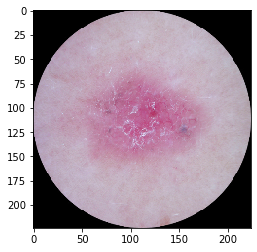

In [62]:
item = TEST_GENERATOR.next()
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

In [63]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, LR]

In [ ]:
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE

########## Training Start
DeepLearning.fit(
        TRAIN_GENERATOR,
        # steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=VALID_GENERATOR)
###########